In [1]:
import json
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Obtaining and processing data to be used in NetworkX

In [2]:
with open('output.json') as f:
    data = json.load(f)

In [10]:
data_subset = data[0:2000]
#data_subset

In [11]:
data_trunc = []
for i in range(0, len(data_subset)):
    if len(data_subset[i]['links']) < 2:   # change to limit amount of friends
        pass
    else:
        data_trunc.append(data_subset[i])
#data_trunc

In [12]:
nodes = [d['name'] for d in data_trunc]
friends = [d['links'] for d in data_trunc]
print(len(friends))
print(len(nodes))

701
701


In [13]:
# Create list of tuple of the relationships between people
edges = []
for i in range(0, len(nodes)):
    for j in range (0, len(friends[i])):
        b = (nodes[i], friends[i][j])
        edges.append(b)
#edges

In [14]:
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

# Remove nodes that are a part of a small disconnected cluster, e.g. has a connection of 20 nodes or less
for component in list(nx.connected_components(graph)):
    if len(component)<15:    # Change this line*****
        for node in component:
            graph.remove_node(node)

#a= list(nx.connected_components(graph))
#a

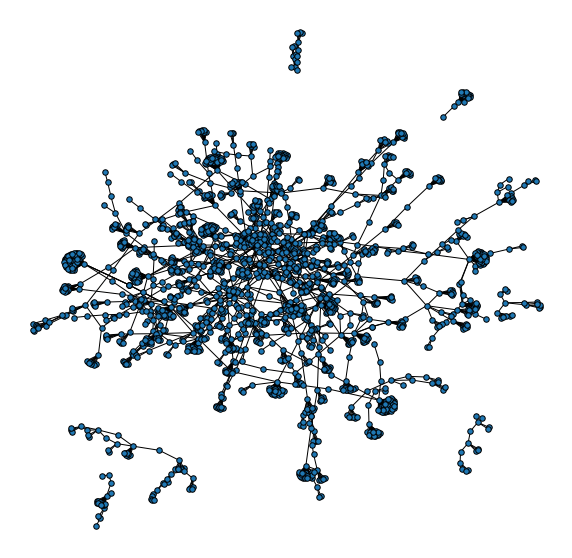

In [15]:
# Plot network
spring_pos = nx.spring_layout(graph)
plt.figure(figsize=(10,10))
plt.axis("off")
nx.draw_networkx(graph,pos = spring_pos, with_labels = False, node_size = 30, linewidths = 1)
ax = plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.show()

In [16]:
print(nx.info(graph)+'\n')

# Shows Network Density
density = nx.density(graph)
print("Network density:", density)

Name: 
Type: Graph
Number of nodes: 2018
Number of edges: 2109
Average degree:   2.0902

Network density: 0.0010362857239725957


Measure of degree and centrality - Including, degrees, eigenvector centrality, and betweenness

In [17]:
# Define dicts containing centrality values
betweenness_dict = nx.betweenness_centrality(graph, normalized=True, endpoints=True)
degree_dict = dict(graph.degree(graph.nodes())) 
eigenvector_dict = nx.eigenvector_centrality_numpy(graph)

# Add as a node attrribute
nx.set_node_attributes(graph, degree_dict, 'degree')
nx.set_node_attributes(graph, betweenness_dict, 'betweenness')
nx.set_node_attributes(graph, eigenvector_dict, 'eigenvector')

# Sort the top 10 in descending order
sorted_betweenness = sorted(betweenness_dict, key=betweenness_dict.get, reverse=True)[:10]
sorted_degree = sorted(degree_dict, key=degree_dict.get, reverse=True)[:10]
sorted_eigenvector = sorted(eigenvector_dict, key=eigenvector_dict.get, reverse=True)[:10]

In [19]:

# Summary of top 10 people by betweenness, and other metrics
for tb in sorted_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb]
    centrality = betweenness_dict[tb] # Use degree_dict to access a node's degree, see footnote 2
    print("Name:", tb, "| Betweenness Centrality:", round(centrality,4), "| Degree:", degree)



Name: Grover_Cleveland | Betweenness Centrality: 0.3874 | Degree: 24
Name: Robert_Gascoyne-Cecil,_3rd_Marquess_of_Salisbury | Betweenness Centrality: 0.3525 | Degree: 52
Name: James_G._Blaine | Betweenness Centrality: 0.2562 | Degree: 25
Name: Edward_VII | Betweenness Centrality: 0.1955 | Degree: 12
Name: Clements_Markham | Betweenness Centrality: 0.1776 | Degree: 23
Name: Morris_Ketchum_Jesup | Betweenness Centrality: 0.1598 | Degree: 5
Name: Nicholas_II_of_Russia | Betweenness Centrality: 0.1503 | Degree: 2
Name: Louis_Lemercier_de_Neuville | Betweenness Centrality: 0.1503 | Degree: 9
Name: %C3%89mile_Zola | Betweenness Centrality: 0.1484 | Degree: 4
Name: John_Stewart_Kennedy | Betweenness Centrality: 0.1418 | Degree: 13


Community Detection

In [20]:
num_of_connections = len(list(nx.connected_components(graph))) # Number of connected components in the whole graph
num_of_connections

12

In [21]:
from networkx.algorithms.community.centrality import girvan_newman
import itertools

comp = girvan_newman(graph)

k=30  # Choose how many communities is wanted
num_of_connections = len(list(nx.connected_components(graph))) # Number of connected components in the whole graph
print('Communites =',k,'\n')
print('Connected components =', num_of_connections,'\n')

if num_of_connections >= k:
     print("Error: Number of communities less than number of connected graphs.\nChoose a value of k < num_of_connections")
else:
     limited = itertools.takewhile(lambda c: len(c) <= k, comp)

     for communities in limited:
          a = list(sorted(c) for c in communities) 


Communites = 30 

Connected components = 12 



In [12]:
#x = input("enter name")

In [22]:
# Graphing communities
# Functions used from https://orbifold.net/default/community-detection-using-networkx/
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)     

In [23]:
# https://orbifold.net/default/community-detection-using-networkx/
set_node_community(graph, communities)
set_edge_community(graph)
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]

external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

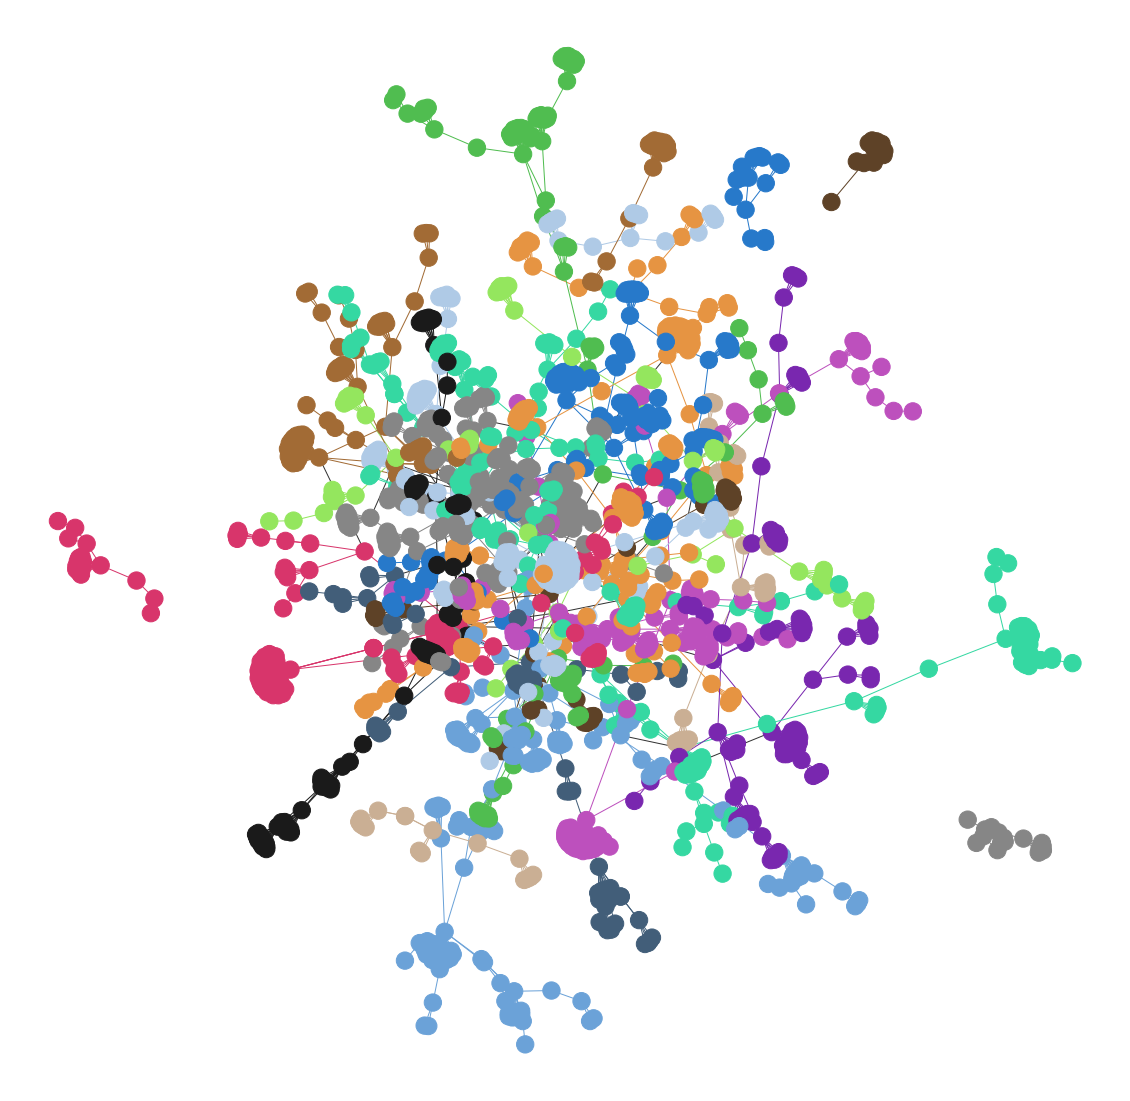

In [24]:
# Plot the communities - adapted from https://orbifold.net/default/community-detection-using-networkx/
karate_pos = nx.spring_layout(graph)
# Draw external edges

plt.figure(figsize=(20,20))
plt.axis("off")
nx.draw_networkx(
        graph, pos=karate_pos, node_size=0,
        edgelist=external, edge_color="#333333", with_labels=False)
# Draw nodes and internal edges
nx.draw_networkx(
        graph, pos=karate_pos, node_color=node_color,
        edgelist=internal, edge_color=internal_color, with_labels= False)

In [25]:
# Search for a person and their community
search = 'Gevheri_Kad%C4%B1n'
for i in range(0, len(a)):
    for j in range(0, len(a[i])):
    #pass
        if a[i][j] == search:
            com_group = a[i]
            print('Person found! Their community is:')
            break
series = pd.Series(com_group).astype(str)
print(series)

Person found! Their community is:
0               %C5%9Eehzade_Yusuf_Izzeddin
1                            Abd%C3%BClaziz
2                             Abdulmejid_II
3                              Aisha_Taymur
4                    Al-Zubayr_Rahma_Mansur
                      ...                  
85    William_Barlow_(dean_of_Peterborough)
86      William_Duncombe,_Viscount_Helmsley
87          William_Hicks_(British_soldier)
88                     William_McEntyre_Dye
89                            Zia_Mohyeddin
Length: 90, dtype: object
